# 1.0 Libraries and functions

In [2]:
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot as plt
import xgboost            as xgb

from sklearn                 import preprocessing    as pp
from sklearn.model_selection import train_test_split
from sklearn                 import metrics          as m
from sklearn                 import model_selection  as ms

from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier

from sklearn.linear_model    import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.metrics         import RocCurveDisplay
from sklearn.metrics         import classification_report
from sklearn.metrics         import confusion_matrix
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.naive_bayes     import CategoricalNB
from sklearn.naive_bayes     import GaussianNB
from sklearn                 import svm
# from lightgbm                import LGBMClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from imblearn.combine        import SMOTETomek

In [3]:
def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)

    precision_list = []
    recall_list = []
    accuracy_list = []
    f1_list = []
    mcc_list = []
    roc_list = []

    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict(x_val_fold)

        x_val_fold['response'] = y_val_fold

        # model precision
        precision = round(m.precision_score(y_val_fold, yhat_model),3)
        # recall
        recall = round(m.recall_score(y_val_fold, yhat_model),3)
        # model accuracy
        accuracy = round(m.accuracy_score(y_val_fold, yhat_model),3)
        # f1-score
        f1 = round(m.f1_score(y_val_fold, yhat_model),3)
        # mcc
        mcc = round(m.matthews_corrcoef(y_val_fold, yhat_model),3)
        #Roc_auc
        roc = round(m.roc_auc_score(y_val_fold,yhat_model),3)

        precision_list.append(precision)
        recall_list.append(recall)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        mcc_list.append(mcc)
        roc_list.append(roc)

        i+=1

    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    accuracy_str = np.round(np.mean(accuracy_list),4).astype(str) + ' +/- ' + np.round(np.std(accuracy_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)
    mcc_str = np.round(np.mean(mcc_list),4).astype(str) + ' +/- ' + np.round(np.std(mcc_list),4).astype(str)
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)

    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, accuracy_str, f1_str, mcc_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance

In [4]:
def plot_confusion_matrix(conf_matrix, title='Confusion Matrix', labels=None):
    sns.set_theme(style="white", palette=None)

    fig, ax = plt.subplots(figsize=(12, 10))
    aa = ax.matshow(conf_matrix, cmap='magma', alpha=0.8)
    aa.set_clim(0,conf_matrix.sum(axis=1).max())
    fig.colorbar(aa, ax=ax)

    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center',color='black')

    ax.tick_params(labelsize=18)

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    if labels is None:
        plt.xticks(np.arange(conf_matrix.shape[0]))
        plt.yticks(np.arange(conf_matrix.shape[1]))
    else:
        plt.xticks(np.arange(conf_matrix.shape[0]), labels)
        plt.yticks(np.arange(conf_matrix.shape[1]), labels)
    plt.title(title, fontsize=18)


    plt.grid(False)
    plt.show()

# 2.0 About Dataset

In [5]:
# Upload do Dataset
df = pd.read_csv('diabetes_data_upload.csv')
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [6]:
# Quantidade de linhas e colunas
print('Quantidade de linhas:', df.shape[0])
print('Quantidade de colunas:', df.shape[1])

Quantidade de linhas: 520
Quantidade de colunas: 17


In [7]:
# Tipo de dado de cada coluna e verificação de valores nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [ ]:
# Total de valores nulos por coluna
df.isnull().sum()

Age                   0
Gender                0
Polyuria              0
Polydipsia            0
sudden weight loss    0
weakness              0
Polyphagia            0
Genital thrush        0
visual blurring       0
Itching               0
Irritability          0
delayed healing       0
partial paresis       0
muscle stiffness      0
Alopecia              0
Obesity               0
class                 0
dtype: int64

In [ ]:
# Colunas do dataset
df.columns

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity', 'class'],
      dtype='object')

In [ ]:
# Quantidade de classe positiva e negativa
df['class'].value_counts(normalize=True)

class
Positive    0.615385
Negative    0.384615
Name: proportion, dtype: float64

In [ ]:
# Estatística descritiva do dataset para cada classe
df.groupby('class').describe()

Age                                                    
          count       mean        std   min   25%   50%   75%   max
class                                                              
Negative  200.0  46.360000  12.080983  26.0  37.0  45.0  55.0  72.0
Positive  320.0  49.071875  12.097481  16.0  39.0  48.0  57.0  90.0

In [ ]:
# Proporção dos dados por gênero
df['Gender'].value_counts(normalize=True)

Gender
Male      0.630769
Female    0.369231
Name: proportion, dtype: float64

# 3.0 Exploratory Data Analysis

## 3.1 Age

In [ ]:
# Renomeadas as colunas de Age e Class para o português: Idade e Classe
df_plot = df
df_plot = df_plot.rename(columns={'Age':'Idade'})
df_plot = df_plot.rename(columns={'class':'classe'})

C:\Users\luan_\AppData\Local\Temp\ipykernel_28604\1612542259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['classe'][df_plot['classe']=='Negative'] = df_plot['classe'].replace('Negative','Negativa')
C:\Users\luan_\AppData\Local\Temp\ipykernel_28604\1612542259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['classe'][df_plot['classe']=='Positive'] = df_plot['classe'].replace('Positive','Positiva')


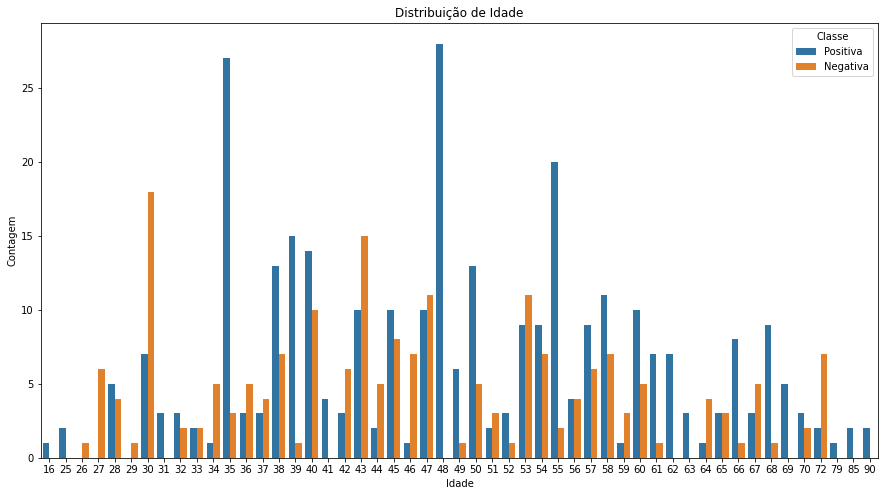

In [ ]:
# Distribuição de idade por gênero
df_plot['classe'][df_plot['classe']=='Negative'] = df_plot['classe'].replace('Negative','Negativa')
df_plot['classe'][df_plot['classe']=='Positive'] = df_plot['classe'].replace('Positive','Positiva')
fig, axs = plt.subplots(nrows= 1, figsize = (15,8))
sns.countplot(x = 'Idade', data=df_plot, hue='classe').set(title='Distribuição de Idade');
plt.ylabel('Contagem')
plt.legend(loc='upper right', title='Classe')

## 3.2 Gender

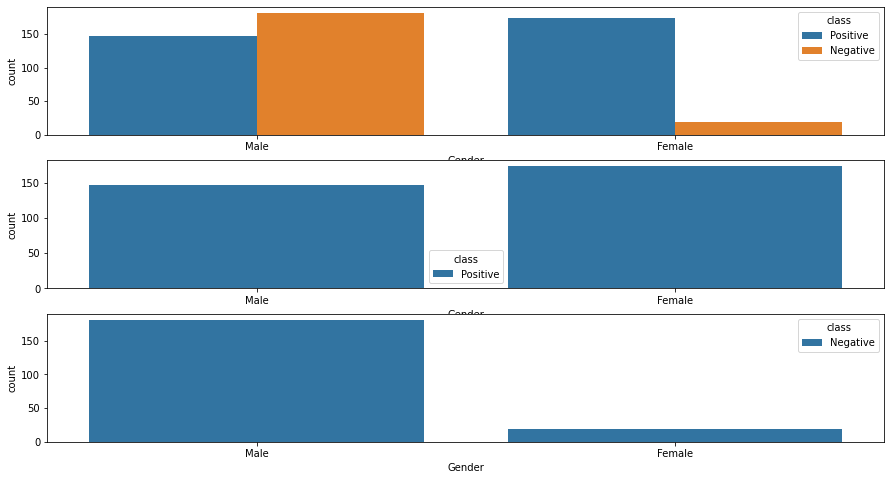

In [ ]:
# Distribuição de gênero por classe
fig, axs = plt.subplots(nrows= 3, figsize = (15,8))
sns.countplot(x = 'Gender', data=df,hue='class',ax=axs[0]);
sns.countplot(x = 'Gender', data=df[df['class']=='Positive'],hue='class',ax=axs[1]);
sns.countplot(x = 'Gender', data=df[df['class']=='Negative'],hue='class',ax=axs[2]);


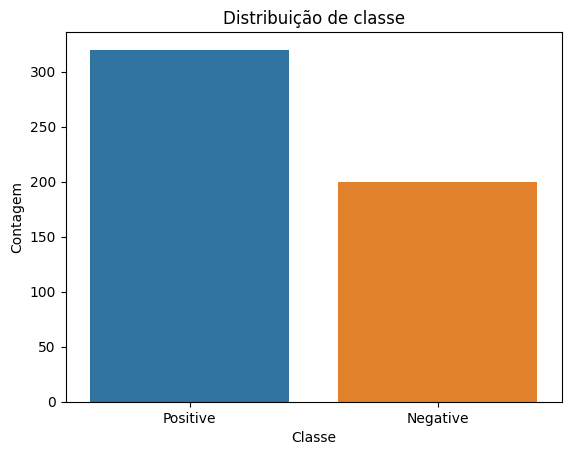

In [ ]:
sns.countplot(x = 'classe', data=df_plot).set(title='Distribuição de classe');
plt.xlabel('Classe');
plt.ylabel('Contagem');

## 3.3 Polyuria

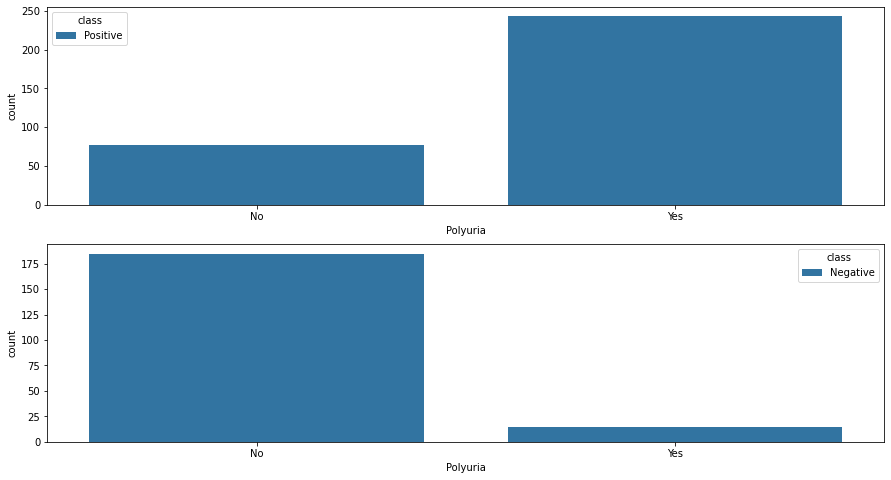

In [ ]:
# Distribuição de Polyuria por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Polyuria', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Polyuria', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.4 Polydipsia

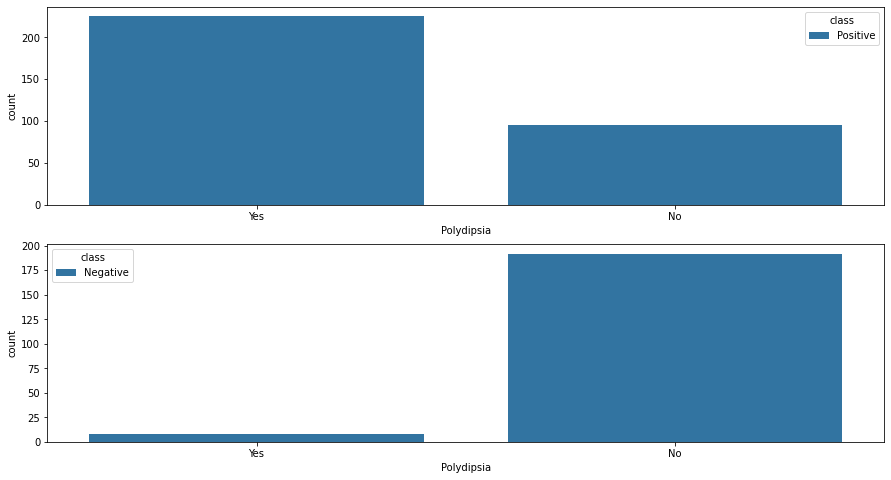

In [ ]:
# Distribuição de Polydipsia por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Polydipsia', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Polydipsia', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.5 Sudden weight loss

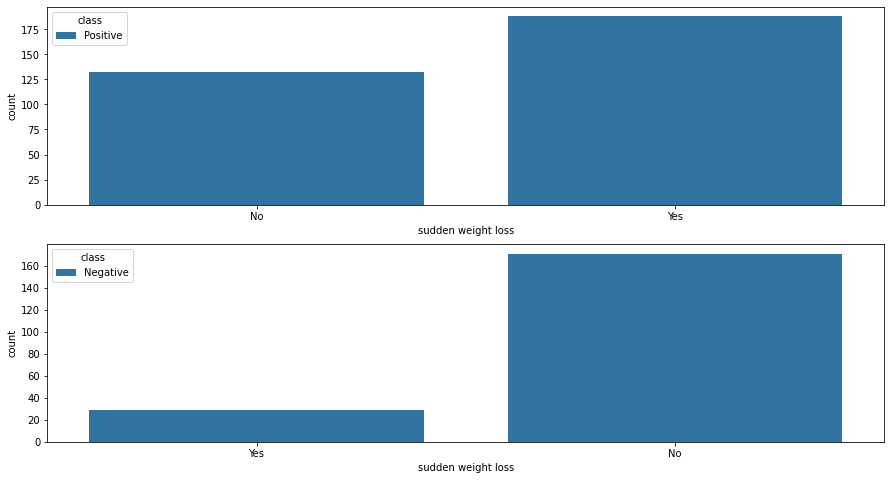

In [ ]:
# Distribuição de Sudden Weight Loss por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'sudden weight loss', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'sudden weight loss', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.6 Weakness

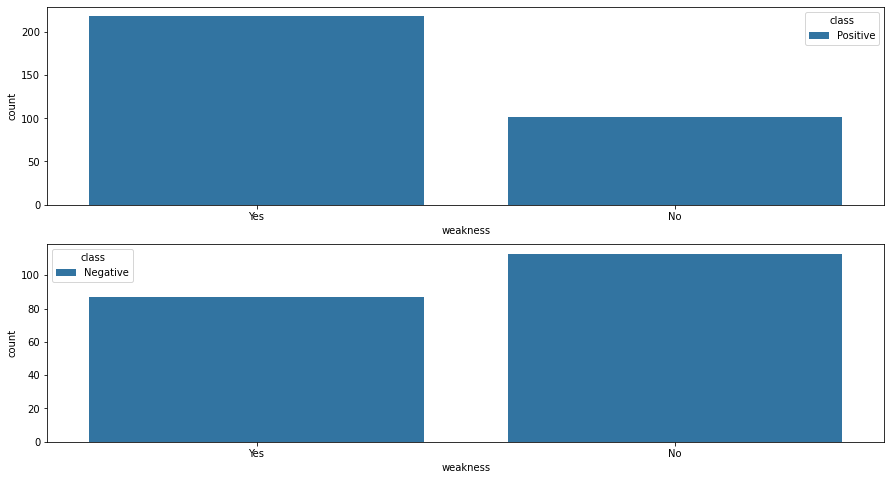

In [ ]:
# Distribuição de Weakness por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'weakness', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'weakness', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.7 Polyphagia

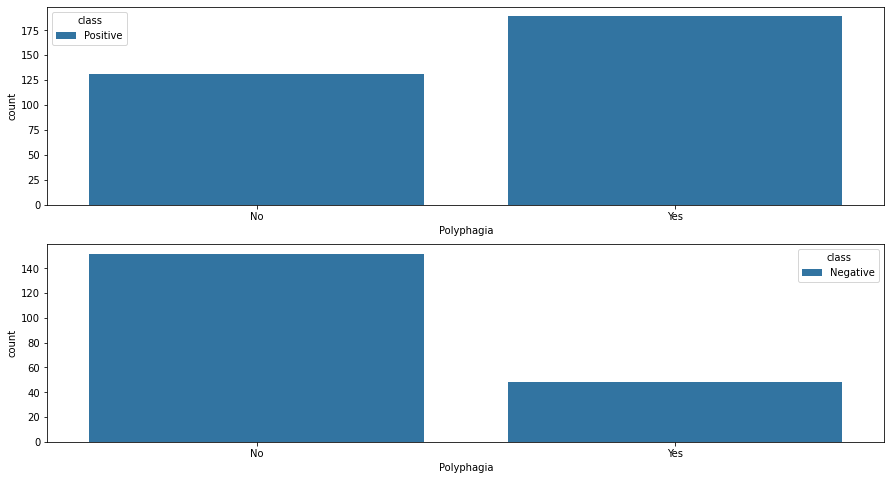

In [ ]:
# Distribuição de Polyphagia por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Polyphagia', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Polyphagia', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.8 Genital Thrush

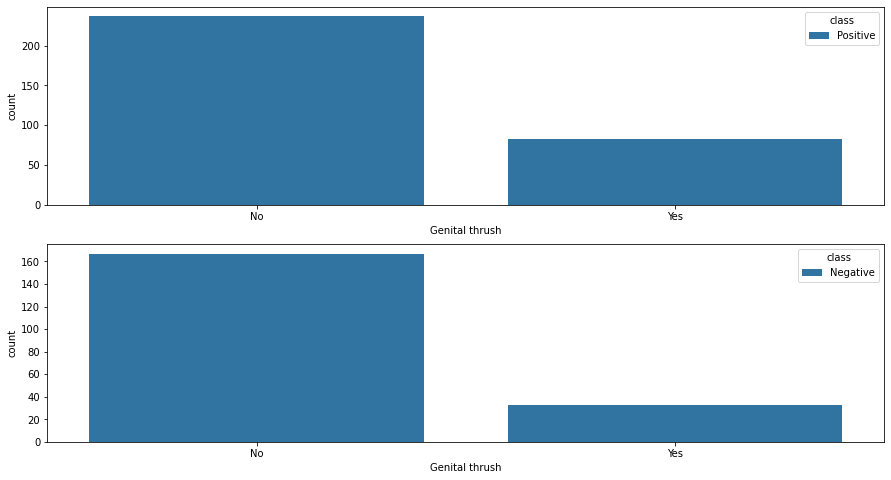

In [ ]:
# Distribuição de Genital Thrush por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Genital thrush', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Genital thrush', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.9 Visual Blurring

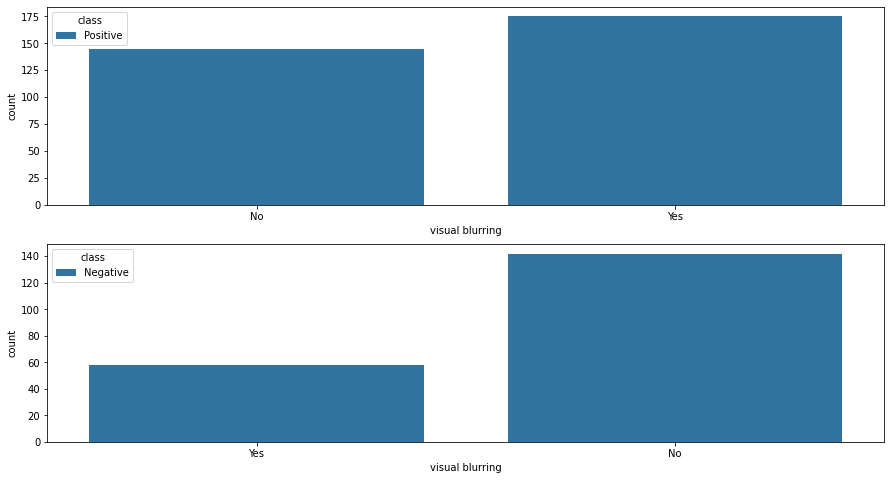

In [ ]:
# Distribuição de Visual Blurring por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'visual blurring', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'visual blurring', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.10 Itching

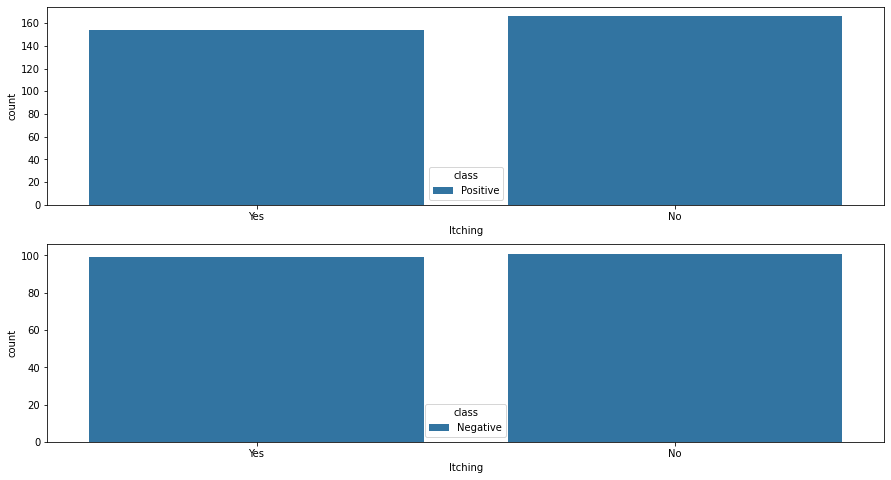

In [ ]:
# Distribuição de Itching por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Itching', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Itching', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.11 Irritability

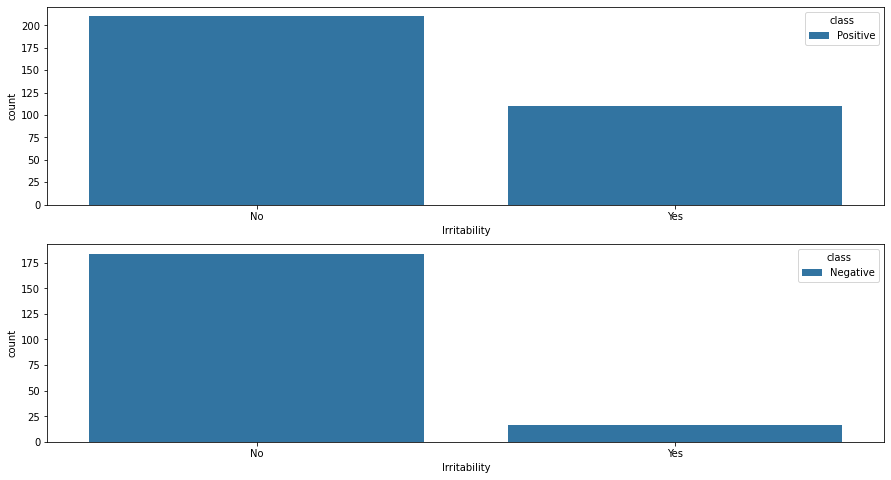

In [ ]:
# Distribuição de Irritability por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Irritability', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Irritability', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.12 Delayed Healing

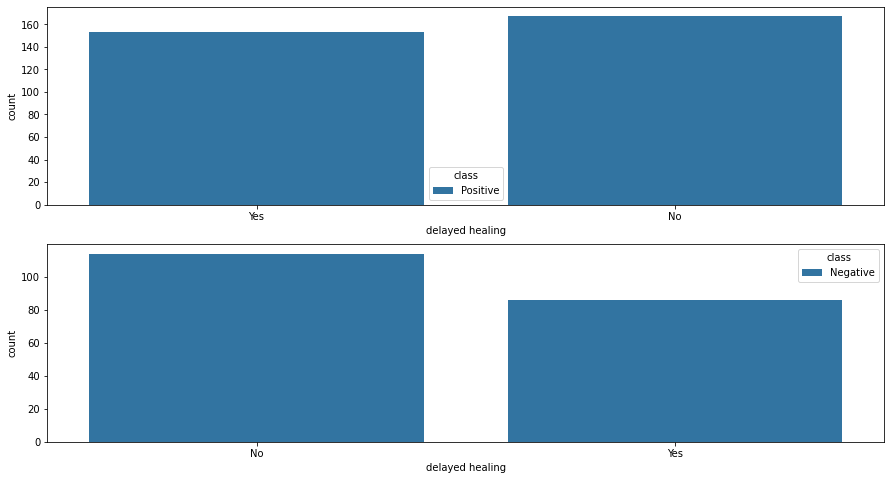

In [ ]:
# Distribuição de Delayed Healing por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'delayed healing', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'delayed healing', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.13 Partial paresis

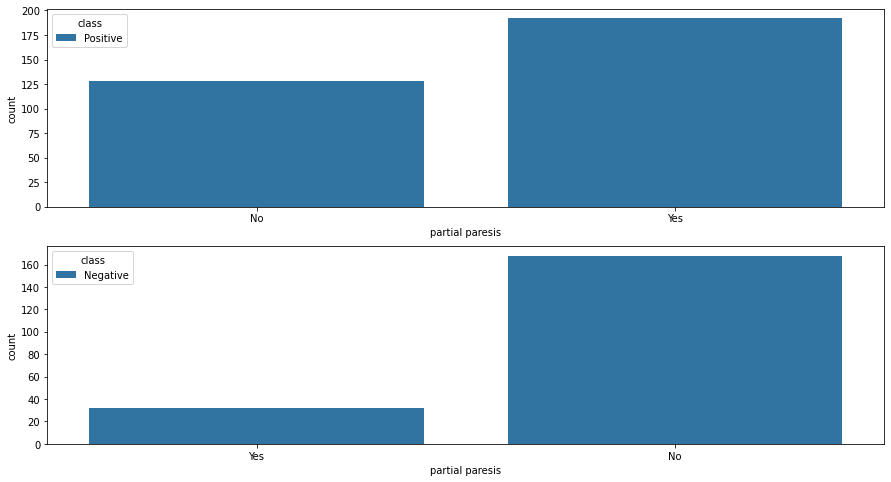

In [ ]:
# Distribuição de Partial Paresis por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'partial paresis', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'partial paresis', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.14 Muscle Stiffness

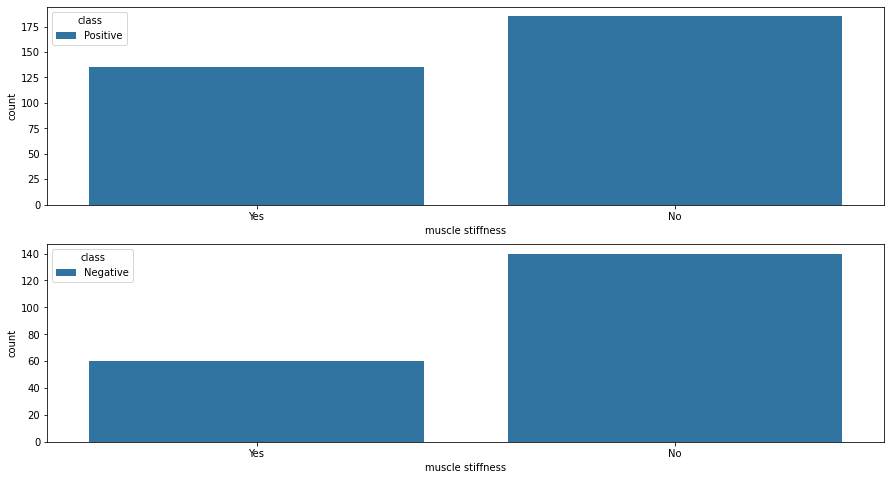

In [ ]:
# Distribuição de Muscle Stiffness por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'muscle stiffness', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'muscle stiffness', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.15 Alopecia

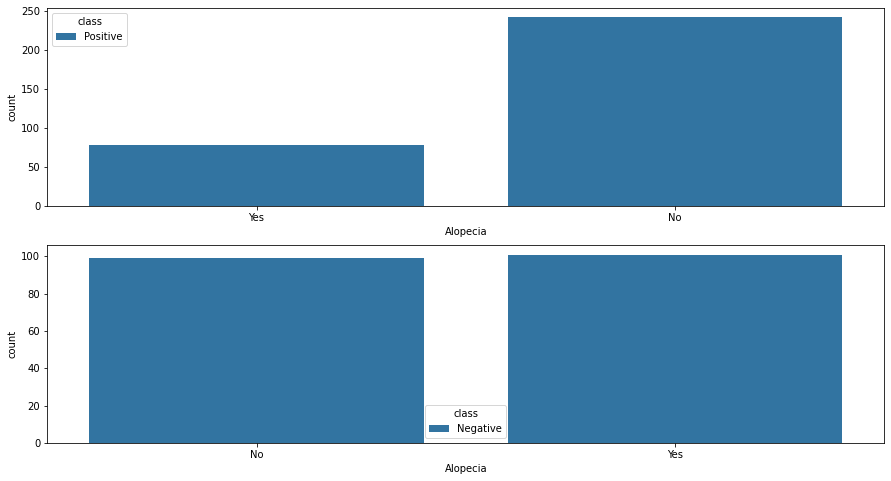

In [ ]:
# Distribuição de Alopecia por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Alopecia', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Alopecia', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.16 Obesity

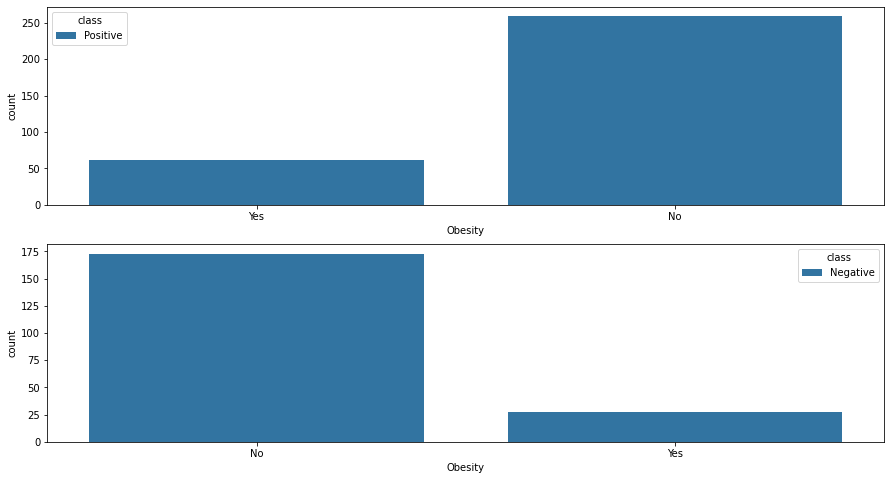

In [ ]:
# Distribuição de Obesity por classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Obesity', data=df[df['class']=='Positive'],hue='class',ax=axs[0]);
sns.countplot(x = 'Obesity', data=df[df['class']=='Negative'],hue='class',ax=axs[1]);

## 3.17 Polyuria and Polydipsia

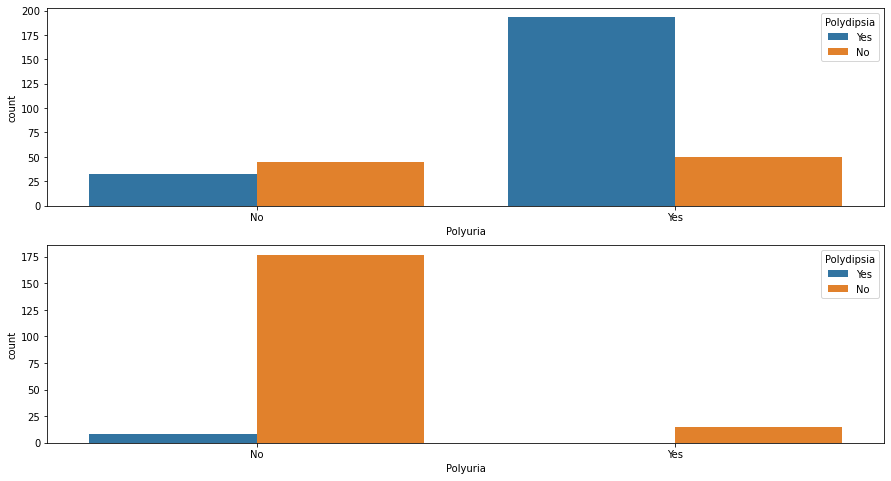

In [ ]:
# Relação entre Polyuria e Polydipsia para cada classe
fig, axs = plt.subplots(nrows= 2, figsize = (15,8))
sns.countplot(x = 'Polyuria', data=df[df['class']=='Positive'],hue='Polydipsia',ax=axs[0]);
sns.countplot(x = 'Polyuria', data=df[df['class']=='Negative'],hue='Polydipsia',ax=axs[1]);

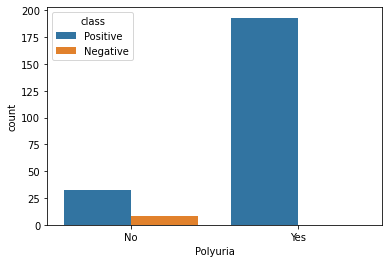

In [ ]:
sns.countplot(x = 'Polyuria', data=df[df['Polydipsia']=='Yes'],hue='class');

# 4.0 Data Preparation

In [8]:
df2 = df.copy()

## 4.1 Converting categorical data to numeric

In [11]:
# Conversão dos dados categoricos para numericos
df2['class'][df2['class']=='Negative'] = df2['class'].replace('Negative',0)
df2['class'][df2['class']=='Positive'] = df2['class'].replace('Positive',1)
df2['class'] = df2['class'].astype(int)

df2['Gender'][df2['Gender']=='Male'] = df2['Gender'].replace('Male',0)
df2['Gender'][df2['Gender']=='Female'] = df2['Gender'].replace('Female',1)
df2['Gender'] = df2['Gender'].astype(int)

df2['Polyuria'][df2['Polyuria']=='No'] = df2['Polyuria'].replace('No',0)
df2['Polyuria'][df2['Polyuria']=='Yes'] = df2['Polyuria'].replace('Yes',1)
df2['Polyuria'] = df2['Polyuria'].astype(int)

df2['Polydipsia'][df2['Polydipsia']=='No'] = df2['Polydipsia'].replace('No',0)
df2['Polydipsia'][df2['Polydipsia']=='Yes'] = df2['Polydipsia'].replace('Yes',1)
df2['Polydipsia'] = df2['Polydipsia'].astype(int)

df2['sudden weight loss'][df2['sudden weight loss']=='No'] = df2['sudden weight loss'].replace('No',0)
df2['sudden weight loss'][df2['sudden weight loss']=='Yes'] = df2['sudden weight loss'].replace('Yes',1)
df2['sudden weight loss'] = df2['sudden weight loss'].astype(int)

df2['weakness'][df2['weakness']=='No'] = df2['weakness'].replace('No',0)
df2['weakness'][df2['weakness']=='Yes'] = df2['weakness'].replace('Yes',1)
df2['weakness'] = df2['weakness'].astype(int)

df2['Polyphagia'][df2['Polyphagia']=='No'] = df2['Polyphagia'].replace('No',0)
df2['Polyphagia'][df2['Polyphagia']=='Yes'] = df2['Polyphagia'].replace('Yes',1)
df2['Polyphagia'] = df2['Polyphagia'].astype(int)

df2['Genital thrush'][df2['Genital thrush']=='No'] = df2['Genital thrush'].replace('No',0)
df2['Genital thrush'][df2['Genital thrush']=='Yes'] = df2['Genital thrush'].replace('Yes',1)
df2['Genital thrush'] = df2['Genital thrush'].astype(int)

df2['visual blurring'][df2['visual blurring']=='No'] = df2['visual blurring'].replace('No',0)
df2['visual blurring'][df2['visual blurring']=='Yes'] = df2['visual blurring'].replace('Yes',1)
df2['visual blurring'] = df2['visual blurring'].astype(int)

df2['Itching'][df2['Itching']=='No'] = df2['Itching'].replace('No',0)
df2['Itching'][df2['Itching']=='Yes'] = df2['Itching'].replace('Yes',1)
df2['Itching'] = df2['Itching'].astype(int)

df2['Irritability'][df2['Irritability']=='No'] = df2['Irritability'].replace('No',0)
df2['Irritability'][df2['Irritability']=='Yes'] = df2['Irritability'].replace('Yes',1)
df2['Irritability'] = df2['Irritability'].astype(int)

df2['delayed healing'][df2['delayed healing']=='No'] = df2['delayed healing'].replace('No',0)
df2['delayed healing'][df2['delayed healing']=='Yes'] = df2['delayed healing'].replace('Yes',1)
df2['delayed healing'] = df2['delayed healing'].astype(int)

df2['partial paresis'][df2['partial paresis']=='No'] = df2['partial paresis'].replace('No',0)
df2['partial paresis'][df2['partial paresis']=='Yes'] = df2['partial paresis'].replace('Yes',1)
df2['partial paresis'] = df2['partial paresis'].astype(int)

df2['muscle stiffness'][df2['muscle stiffness']=='No'] = df2['muscle stiffness'].replace('No',0)
df2['muscle stiffness'][df2['muscle stiffness']=='Yes'] = df2['muscle stiffness'].replace('Yes',1)
df2['muscle stiffness'] = df2['muscle stiffness'].astype(int)

df2['Alopecia'][df2['Alopecia']=='No'] = df2['Alopecia'].replace('No',0)
df2['Alopecia'][df2['Alopecia']=='Yes'] = df2['Alopecia'].replace('Yes',1)
df2['Alopecia'] = df2['Alopecia'].astype(int)

df2['Obesity'][df2['Obesity']=='No'] = df2['Obesity'].replace('No',0)
df2['Obesity'][df2['Obesity']=='Yes'] = df2['Obesity'].replace('Yes',1)
df2['Obesity'] = df2['Obesity'].astype(int)

In [ ]:
# Verificação do tipo de dado após conversão
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Age                 520 non-null    int64
 1   Gender              520 non-null    int32
 2   Polyuria            520 non-null    int32
 3   Polydipsia          520 non-null    int32
 4   sudden weight loss  520 non-null    int32
 5   weakness            520 non-null    int32
 6   Polyphagia          520 non-null    int32
 7   Genital thrush      520 non-null    int32
 8   visual blurring     520 non-null    int32
 9   Itching             520 non-null    int32
 10  Irritability        520 non-null    int32
 11  delayed healing     520 non-null    int32
 12  partial paresis     520 non-null    int32
 13  muscle stiffness    520 non-null    int32
 14  Alopecia            520 non-null    int32
 15  Obesity             520 non-null    int32
 16  class               520 non-null    int32
dt

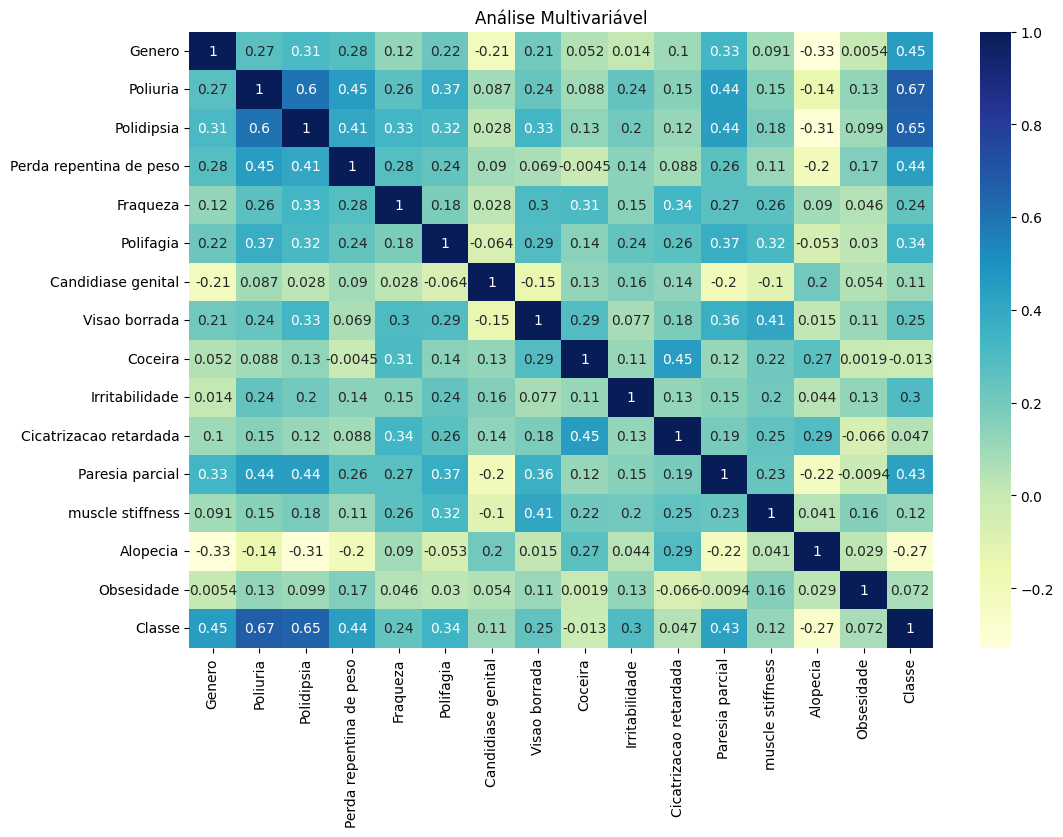

In [ ]:
# Heatmap do dataset
aux1 = df2[df2['class']==1]
num_att = df2.drop(columns=['Age'])
num_att = num_att.rename(columns={'Gender':'Genero',
                                  'Polyuria':'Poliuria',
                                  'Polydipsia':'Polidipsia',
                                  'sudden weight loss':'Perda repentina de peso',
                                  'weakness':'Fraqueza',
                                  'Polyphagia':'Polifagia',
                                  'Genital thrush':'Candidiase genital',
                                  'visual blurring':'Visao borrada',
                                  'Itching':'Coceira',
                                  'Irritability':'Irritabilidade',
                                  'delayed healing':'Cicatrizacao retardada',
                                  'partial paresis':'Paresia parcial',
                                  'muscle stiffiness':'Rigidez muscular',
                                  'Obesity':'Obsesidade',
                                  'class':'Classe',
                                 })
fig = plt.subplots(figsize = (12,8))
sns.heatmap(num_att.corr(), annot = True,cmap="YlGnBu").set(title='Análise Multivariável');


## 4.2 Normalization

In [12]:
# Normalização da coluna Age ou Idade
rbs_age = pp.MinMaxScaler()
df2['Age'] = rbs_age.fit_transform(df2[['Age']].values)

In [13]:
df2.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,0.324324,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,0.567568,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,0.337838,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,0.391892,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,0.594595,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [20]:
# Estatística descritiva da coluna Age após normalização
df2['Age'].describe()

count    520.000000
mean       0.432822
std        0.164209
min        0.000000
25%        0.310811
50%        0.425676
75%        0.554054
max        1.000000
Name: Age, dtype: float64

## 4.2 Train Preparation

In [21]:
# Separação dos atributos e da classe
X = df2.drop('class',axis=1)
y = df2['class'].copy()

In [22]:
# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [23]:
# Quantidade de dados de treino e teste
print('Number of Rows of X_train: {}'.format(X_train.shape[0]))
print('Number of Rows of X_test: {}'.format(X_test.shape[0]))

Number of Rows of X_train: 416
Number of Rows of X_test: 104


In [24]:
# Verificão da proporção das classes - É possível notar que as classes não são balanceadas
y_train.value_counts(), y_test.value_counts()

(1    249
 0    167
 Name: class, dtype: int64,
 1    71
 0    33
 Name: class, dtype: int64)

## 4.3 Balanceamento dos Dados

In [25]:
# Balanceamento das classes usando o SMOTETomek
resampler = SMOTETomek(random_state=42, n_jobs=-1)

# transforms the data set
X_balanced, y_balanced = resampler.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [26]:
# Quantidade de dados após balanceamento
print('Number of Rows: {}'.format(X_balanced.shape[0]))

Number of Rows: 498


In [27]:
# Verificação das classes após balanceamento
y_balanced.value_counts()

1    249
0    249
Name: class, dtype: int64

In [28]:
X_train = X_balanced.copy()
y_train = y_balanced.copy()

# 5.0 Models Training

In [87]:
columns = ['Model', 'Precision', 'Recall', 'Accuracy', 'F1_Score', 'Balanced Accuracy']

## 5.1 Linear Regression

In [88]:
logreg_model = LogisticRegression(penalty='l2', solver='newton-cg')
# model_reglog = logreg_model.fit(X_train,y_train)
# yhat_reglog = model_reglog.predict(X_test)

In [89]:
# Linear Regression
cv_results_lr = cross_validate(logreg_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

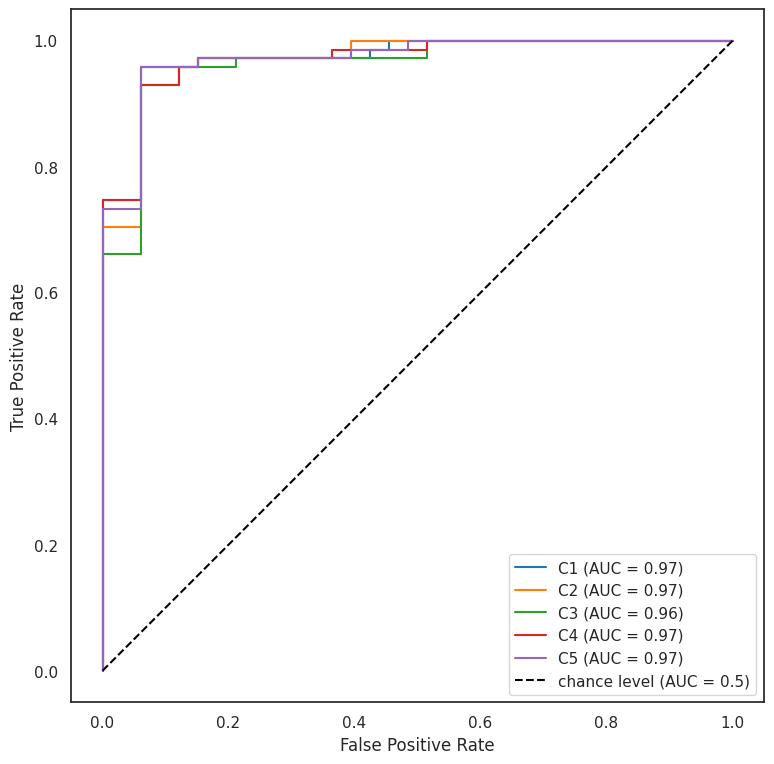

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid, model in enumerate(cv_results_lr['estimator']):
  pred_score = model.predict_proba(X_test)
  # Get Probabilites only for the positive class
  pred_score = pred_score[:, 1]

  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_score,
    name=f"C{cid+1}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.94      0.96      0.95        71

    accuracy                           0.93       104
   macro avg       0.93      0.92      0.92       104
weighted avg       0.93      0.93      0.93       104



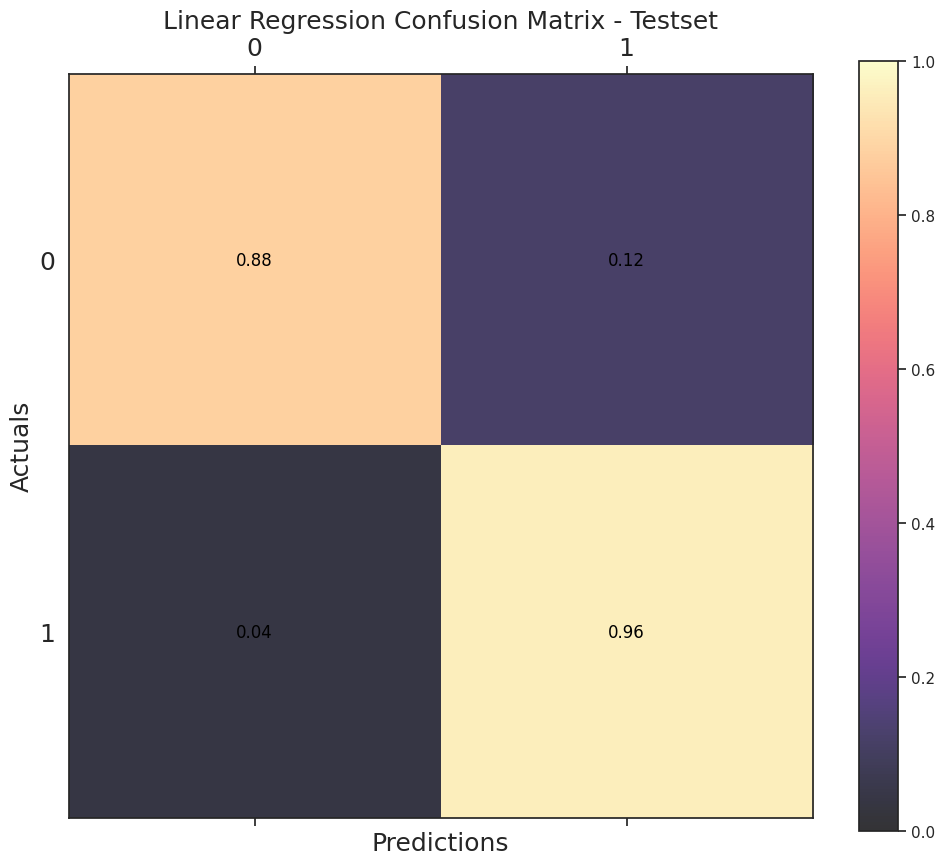

In [91]:
best_model_lr = cv_results_lr['estimator'][0]
test_pred_lr = best_model_lr.predict(X_test)

print(classification_report(y_test, test_pred_lr))

conf_matrix_lr = confusion_matrix(y_test, test_pred_lr, normalize='true')
conf_matrix_lr = np.round(conf_matrix_lr, 2)
plot_confusion_matrix(conf_matrix_lr, title='Linear Regression Confusion Matrix - Testset')

In [92]:
# model precision
precision_logreg = round(m.precision_score(y_test, test_pred_lr),3)
# recall
recall_logreg = round(m.recall_score(y_test, test_pred_lr),3)
# model accuracy
accuracy_logreg = round(m.accuracy_score(y_test, test_pred_lr),3)
# f1-score
f1_logreg = round(m.f1_score(y_test, test_pred_lr),3)
# mcc
mcc_logreg = round(m.matthews_corrcoef(y_test, test_pred_lr),3)
#Roc_auc
roc_logreg = round(m.roc_auc_score(y_test,test_pred_lr),3)
#Acc_bal
accurary_bal_logreg = round(m.balanced_accuracy_score(y_test,test_pred_lr),3)

print("precision: {}" .format(precision_logreg))
print("recall: {}" .format(recall_logreg))
print("accuracy {}".format(accuracy_logreg))
print("f1 {}".format(f1_logreg))
print("mcc {}".format(mcc_logreg))
print("roc {}".format(roc_logreg))
print("accuracy balanced {}".format(accurary_bal_logreg))

precision: 0.944
recall: 0.958
accuracy 0.933
f1 0.951
mcc 0.844
roc 0.918
accuracy balanced 0.918


In [93]:
m.confusion_matrix(y_test, test_pred_lr)

array([[29,  4],
       [ 3, 68]])

In [94]:
best_model_lr.coef_

array([[-0.59233388,  2.39296165,  2.65335297,  2.71833587,  0.8518172 ,
         0.37188085,  0.15619611,  1.23167538,  0.64534643, -1.39281439,
         1.23648842, -0.81176665,  1.09867246, -0.20213921, -0.04511566,
        -0.09280988]])

Text(0.5, 0, 'Logistic Regression Feature Importance')

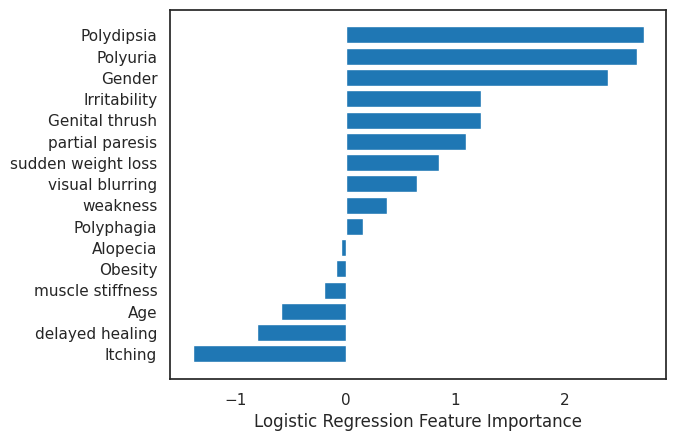

In [95]:
sorted_idx = best_model_lr.coef_[0].argsort()
plt.barh(X.columns[sorted_idx], best_model_lr.coef_[0][sorted_idx])
plt.xlabel("Logistic Regression Feature Importance")

In [96]:
models_performance = pd.DataFrame({'Model':['Logistic Regression'], "Precision": [precision_logreg], "Recall": [recall_logreg], "Accuracy": [accuracy_logreg], "F1_Score": [f1_logreg],"Balanced Accuracy":[accurary_bal_logreg]})

In [97]:
models_performance

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918


## 5.2 Gaussian NB

In [98]:
nbc_model = GaussianNB()
model_nbc = nbc_model.fit(X_train,y_train)
#yhat_nbc = model_nbc.predict(X_test)

In [99]:
cv_results_nbc = cross_validate(nbc_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

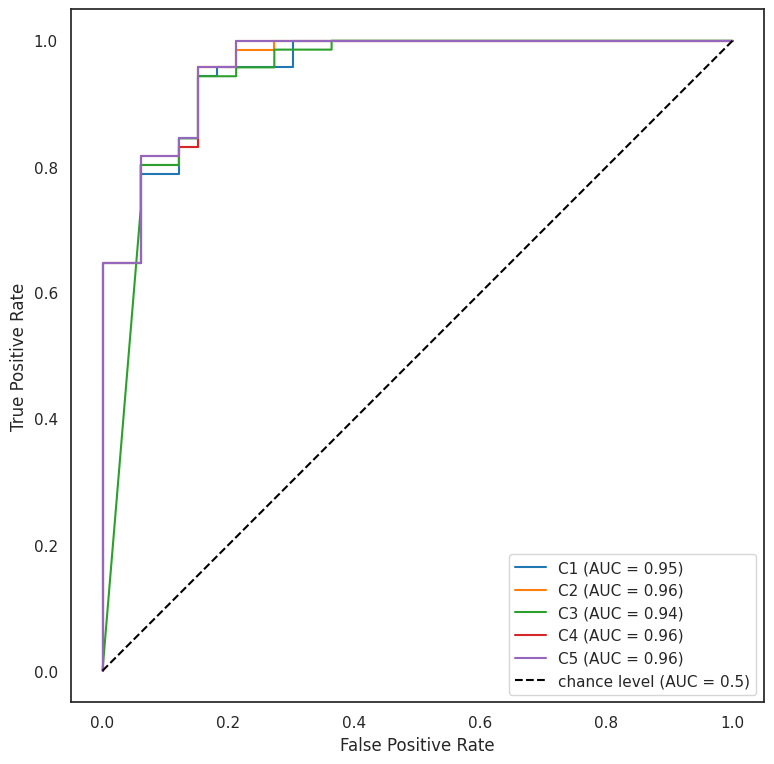

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid, model in enumerate(cv_results_nbc['estimator']):
  pred_score = model.predict_proba(X_test)
  # Get Probabilites only for the positive class
  pred_score = pred_score[:, 1]

  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_score,
    name=f"C{cid+1}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.85      0.86        33
           1       0.93      0.94      0.94        71

    accuracy                           0.91       104
   macro avg       0.90      0.90      0.90       104
weighted avg       0.91      0.91      0.91       104



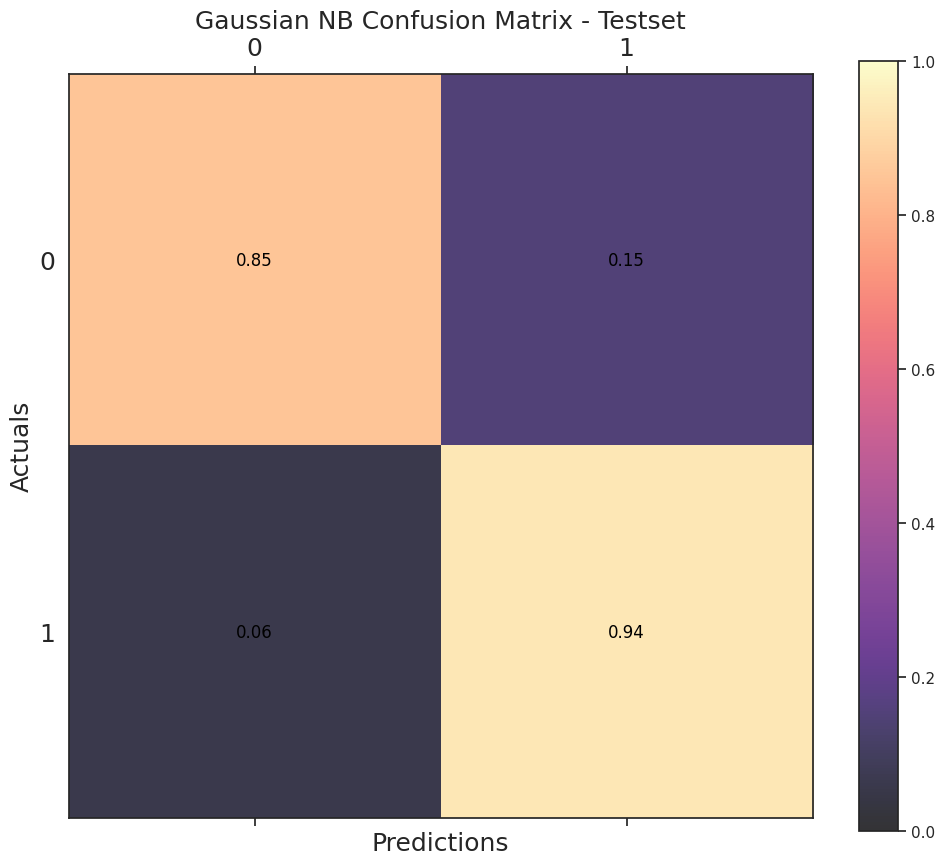

In [101]:
best_model_nbc = cv_results_nbc['estimator'][0]
test_pred_nbc = best_model_nbc.predict(X_test)

print(classification_report(y_test, test_pred_nbc))

conf_matrix_nbc = confusion_matrix(y_test, test_pred_nbc, normalize='true')
conf_matrix_nbc = np.round(conf_matrix_nbc, 2)
plot_confusion_matrix(conf_matrix_nbc, title='Gaussian NB Confusion Matrix - Testset')

In [102]:
# model precision
precision_nbc = round(m.precision_score(y_test, test_pred_nbc),3)
# recall
recall_nbc = round(m.recall_score(y_test, test_pred_nbc),3)
# model accuracy
accuracy_nbc = round(m.accuracy_score(y_test, test_pred_nbc),3)
# f1-score
f1_nbc = round(m.f1_score(y_test, test_pred_nbc),3)
# mcc
mcc_nbc = round(m.matthews_corrcoef(y_test, test_pred_nbc),3)
#Roc_auc
roc_nbc = round(m.roc_auc_score(y_test,test_pred_nbc),3)
#Acc_bal
accurary_bal_nbc = round(m.balanced_accuracy_score(y_test,test_pred_nbc),3)

print("precision: {}" .format(precision_nbc))
print("recall: {}" .format(recall_nbc))
print("accuracy {}".format(accuracy_nbc))
print("f1 {}".format(f1_nbc))
print("mcc {}".format(mcc_nbc))
print("roc {}".format(roc_nbc))
print("accuracy balanced {}".format(accurary_bal_nbc))


precision: 0.931
recall: 0.944
accuracy 0.913
f1 0.937
mcc 0.799
roc 0.896
accuracy balanced 0.896


In [103]:
m.confusion_matrix(y_test, test_pred_nbc)

array([[28,  5],
       [ 4, 67]])

In [104]:
nbc_df = pd.DataFrame([['Naive Bayes Classifier', precision_nbc, recall_nbc, accuracy_nbc, f1_nbc, accurary_bal_nbc]],columns=columns)
models_performance = pd.concat([models_performance,nbc_df],ignore_index=True)

In [105]:
models_performance

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918
1,Naive Bayes Classifier,0.931,0.944,0.913,0.937,0.896


## 5.3 XGBoost

In [106]:
xgb_model = xgb.XGBClassifier(random_state=42, n_jobs=-1)
model_xgb = xgb_model.fit(X_train,y_train)

In [107]:
cv_results_xgb = cross_validate(xgb_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

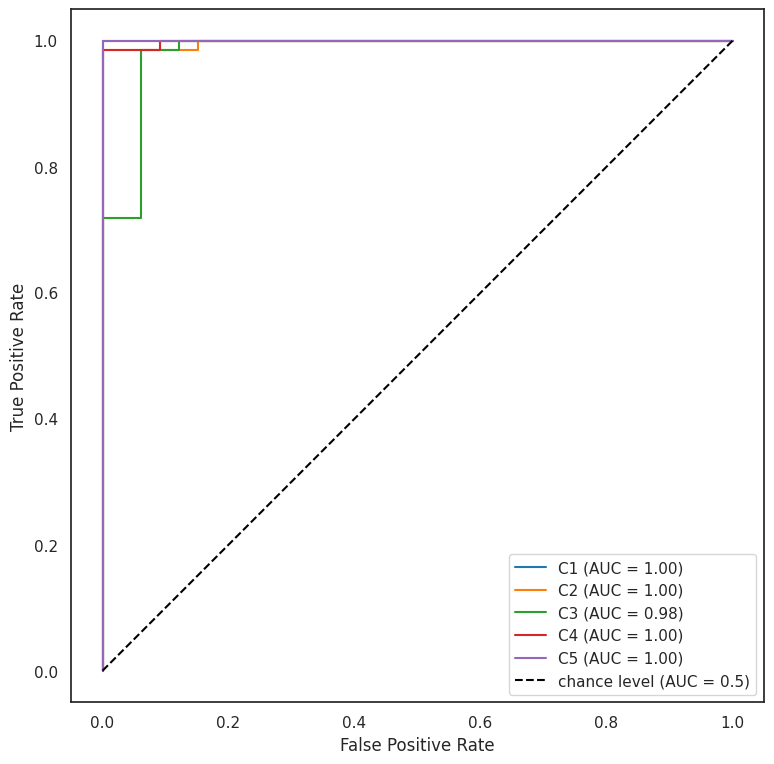

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid, model in enumerate(cv_results_xgb['estimator']):
  pred_score = model.predict_proba(X_test)
  # Get Probabilites only for the positive class
  pred_score = pred_score[:, 1]

  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_score,
    name=f"C{cid+1}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        33
           1       1.00      0.96      0.98        71

    accuracy                           0.97       104
   macro avg       0.96      0.98      0.97       104
weighted avg       0.97      0.97      0.97       104



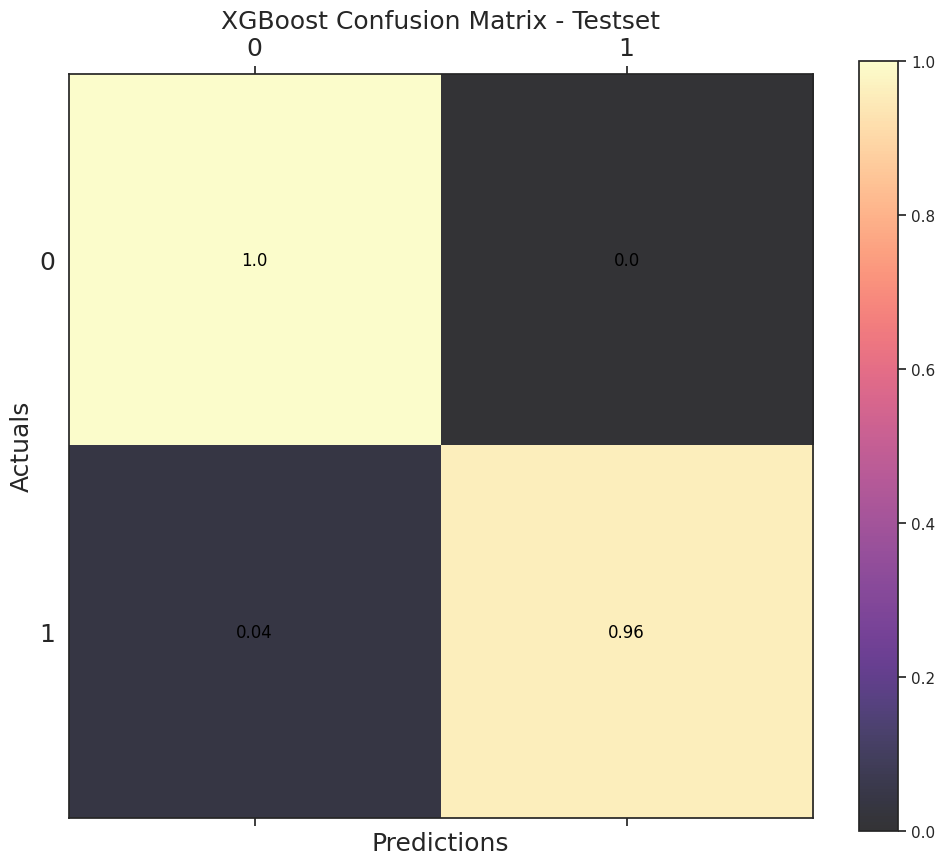

In [109]:
best_model_xgb = cv_results_xgb['estimator'][0]
test_pred_xgb = best_model_xgb.predict(X_test)

print(classification_report(y_test, test_pred_xgb))

conf_matrix_xgb = confusion_matrix(y_test, test_pred_xgb, normalize='true')
conf_matrix_xgb = np.round(conf_matrix_xgb, 2)
plot_confusion_matrix(conf_matrix_xgb, title='XGBoost Confusion Matrix - Testset')

In [110]:
# model precision
precision_xgb = round(m.precision_score(y_test, test_pred_xgb),3)
# recall
recall_xgb = round(m.recall_score(y_test, test_pred_xgb),3)
# model accuracy
accuracy_xgb = round(m.accuracy_score(y_test, test_pred_xgb),3)
# f1-score
f1_xgb = round(m.f1_score(y_test, test_pred_xgb),3)
# mcc
mcc_xgb = round(m.matthews_corrcoef(y_test, test_pred_xgb),3)
#Roc_auc
roc_xgb = round(m.roc_auc_score(y_test,test_pred_xgb),3)
#Acc_bal
accurary_bal_xgb = round(m.balanced_accuracy_score(y_test,test_pred_xgb),3)

print("precision: {}" .format(precision_xgb))
print("recall: {}" .format(recall_xgb))
print("accuracy {}".format(accuracy_xgb))
print("f1 {}".format(f1_xgb))
print("mcc {}".format(mcc_xgb))
print("roc {}".format(roc_xgb))
print("accuracy balanced {}".format(accurary_bal_xgb))

precision: 1.0
recall: 0.958
accuracy 0.971
f1 0.978
mcc 0.937
roc 0.979
accuracy balanced 0.979


In [111]:
m.confusion_matrix(y_test, test_pred_xgb)

array([[33,  0],
       [ 3, 68]])

In [112]:
best_model_xgb.feature_importances_

array([0.02135456, 0.05909235, 0.38655418, 0.18237075, 0.02405073,
       0.01217867, 0.00910721, 0.02710252, 0.02403136, 0.03369699,
       0.02251873, 0.06633464, 0.01797074, 0.03475692, 0.05243451,
       0.02644519], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

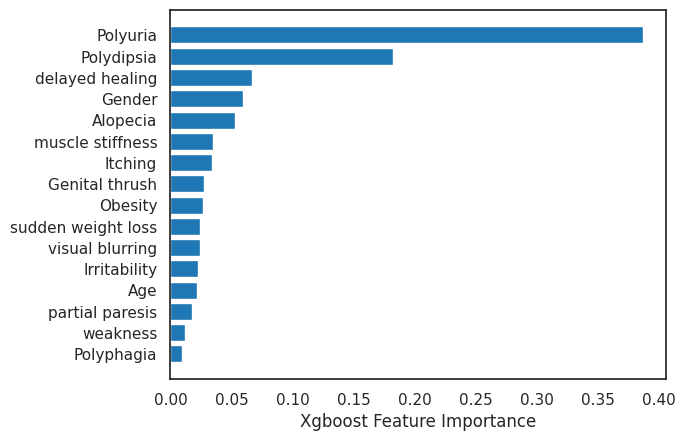

In [113]:
sorted_idx = best_model_xgb.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model_xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [114]:
xgb_df = pd.DataFrame([['XGBoost Classifier', precision_xgb, recall_xgb, accuracy_xgb, f1_xgb, accurary_bal_xgb]],columns=columns)
models_performance = pd.concat([models_performance,xgb_df],ignore_index=True)

In [115]:
models_performance

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918
1,Naive Bayes Classifier,0.931,0.944,0.913,0.937,0.896
2,XGBoost Classifier,1.000,0.958,0.971,0.978,0.979


## 5.4 Random Forest Classifier

In [116]:
#RandomForestClassifier
rfc_model = RandomForestClassifier(random_state=42, n_jobs=-1)
model_rfc = rfc_model.fit(X_train,y_train)

In [117]:
cv_results_rfc = cross_validate(rfc_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

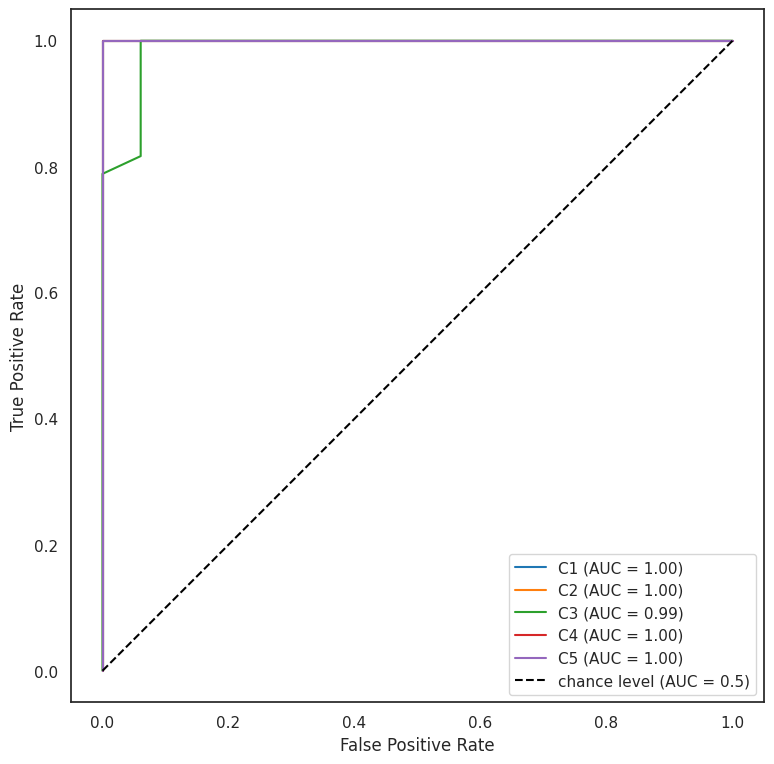

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid, model in enumerate(cv_results_rfc['estimator']):
  pred_score = model.predict_proba(X_test)
  # Get Probabilites only for the positive class
  pred_score = pred_score[:, 1]

  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_score,
    name=f"C{cid+1}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        33
           1       1.00      0.99      0.99        71

    accuracy                           0.99       104
   macro avg       0.99      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104



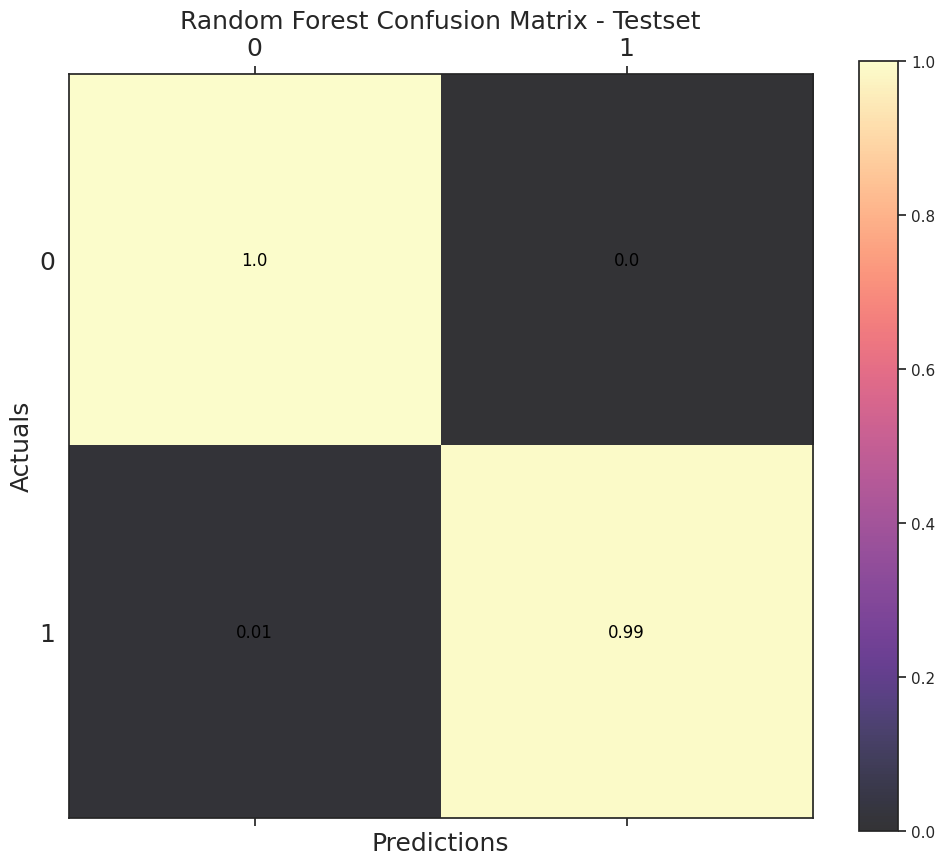

In [119]:
best_model_rfc = cv_results_rfc['estimator'][0]
test_pred_rfc = best_model_rfc.predict(X_test)

print(classification_report(y_test, test_pred_rfc))

conf_matrix_rfc = confusion_matrix(y_test, test_pred_rfc, normalize='true')
conf_matrix_rfc = np.round(conf_matrix_rfc, 2)
plot_confusion_matrix(conf_matrix_rfc, title='Random Forest Confusion Matrix - Testset')

In [120]:
# model precision
precision_rfc = round(m.precision_score(y_test, test_pred_rfc),3)
# recall
recall_rfc = round(m.recall_score(y_test, test_pred_rfc),3)
# model accuracy
accuracy_rfc = round(m.accuracy_score(y_test, test_pred_rfc),3)
# f1-score
f1_rfc = round(m.f1_score(y_test, test_pred_rfc),3)
# mcc
mcc_rfc = round(m.matthews_corrcoef(y_test, test_pred_rfc),3)
#Roc_auc
roc_rfc = round(m.roc_auc_score(y_test,test_pred_rfc),3)
#Acc_bal
accuracy_bal_rfc = round(m.balanced_accuracy_score(y_test,test_pred_rfc),3)

print("precision: {}" .format(precision_rfc))
print("recall: {}" .format(recall_rfc))
print("accuracy {}".format(accuracy_rfc))
print("f1 {}".format(f1_rfc))
print("mcc {}".format(mcc_rfc))
print("roc {}".format(roc_rfc))
print("accuracy_bal_rfc {}".format(accuracy_bal_rfc))

precision: 1.0
recall: 0.986
accuracy 0.99
f1 0.993
mcc 0.978
roc 0.993
accuracy_bal_rfc 0.993


In [121]:
best_model_rfc.feature_importances_

array([0.0962089 , 0.10227973, 0.24264246, 0.1753945 , 0.06445661,
       0.01458943, 0.0222848 , 0.02198067, 0.02444829, 0.03063108,
       0.03393997, 0.03137311, 0.05704689, 0.02233894, 0.04319526,
       0.01718936])

Text(0.5, 0, 'Random Forest Feature Importance')

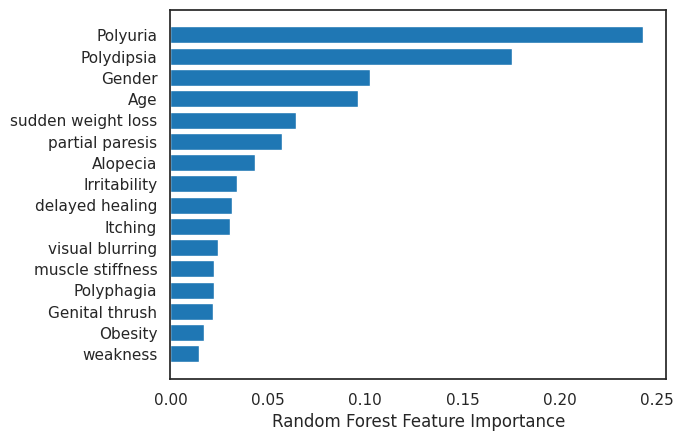

In [122]:
sorted_idx = best_model_rfc.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model_rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [123]:
rfc_df = pd.DataFrame([['Random Forest Classifier', precision_rfc, recall_rfc, accuracy_rfc, f1_rfc, accuracy_bal_rfc]],columns=columns)
models_performance = pd.concat([models_performance,rfc_df],ignore_index=True)

In [124]:
models_performance

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918
1,Naive Bayes Classifier,0.931,0.944,0.913,0.937,0.896
2,XGBoost Classifier,1.000,0.958,0.971,0.978,0.979
3,Random Forest Classifier,1.000,0.986,0.990,0.993,0.993


## 5.5 SVM

In [125]:
svm_model = svm.SVC(kernel="linear", random_state=42)
model_svm = svm_model.fit(X_train,y_train)
yhat_svm = model_svm.predict(X_test)

In [126]:
cv_results_svm = cross_validate(svm_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.96      0.94      0.95        71

    accuracy                           0.93       104
   macro avg       0.92      0.93      0.92       104
weighted avg       0.93      0.93      0.93       104



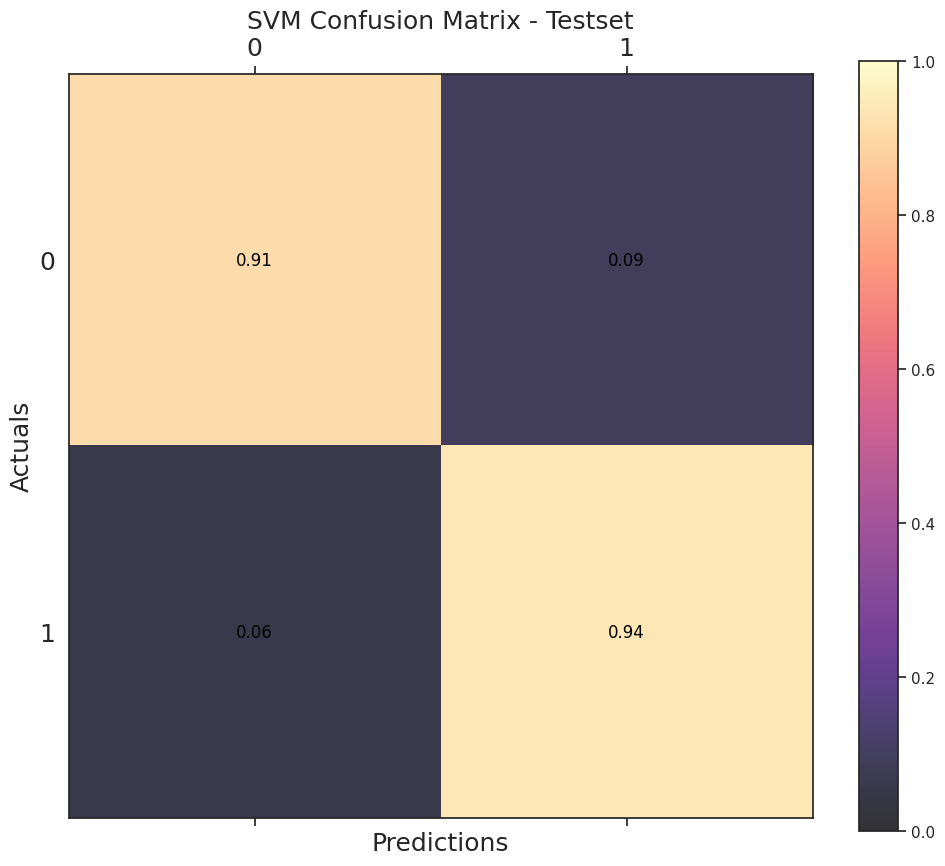

In [127]:
best_model_svm = cv_results_svm['estimator'][0]
test_pred_svm = best_model_svm.predict(X_test)

print(classification_report(y_test, test_pred_svm))

conf_matrix_svm = confusion_matrix(y_test, test_pred_svm, normalize='true')
conf_matrix_svm = np.round(conf_matrix_svm, 2)
plot_confusion_matrix(conf_matrix_svm, title='SVM Confusion Matrix - Testset')

In [128]:
# model precision
precision_svm = round(m.precision_score(y_test, test_pred_svm),3)
# recall
recall_svm = round(m.recall_score(y_test, test_pred_svm),3)
# model accuracy
accuracy_svm = round(m.accuracy_score(y_test, test_pred_svm),3)
# f1-score
f1_svm = round(m.f1_score(y_test, test_pred_svm),3)
# mcc
mcc_svm = round(m.matthews_corrcoef(y_test, test_pred_svm),3)
#Roc_auc
roc_svm = round(m.roc_auc_score(y_test,test_pred_svm),3)
#Acc_bal
accuracy_bal_svm = round(m.balanced_accuracy_score(y_test,test_pred_svm),3)

print("precision: {}" .format(precision_svm))
print("recall: {}" .format(recall_svm))
print("accuracy {}".format(accuracy_svm))
print("f1 {}".format(f1_svm))
print("mcc {}".format(mcc_svm))
print("roc {}".format(roc_svm))
print("accuracy balanced {}".format(accuracy_bal_svm))

precision: 0.957
recall: 0.944
accuracy 0.933
f1 0.95
mcc 0.846
roc 0.926
accuracy balanced 0.926


In [129]:
best_model_svm.coef_[0]

array([-0.92777827,  1.92406106,  1.73533341,  1.99687266,  0.6024263 ,
        0.33206709,  0.18970798,  0.62569174,  0.29526005, -1.10602807,
        0.78966231, -0.72560114,  0.87940751, -0.20778756,  0.09303471,
       -0.30438553])

Text(0.5, 0, 'SVM Feature Importance')

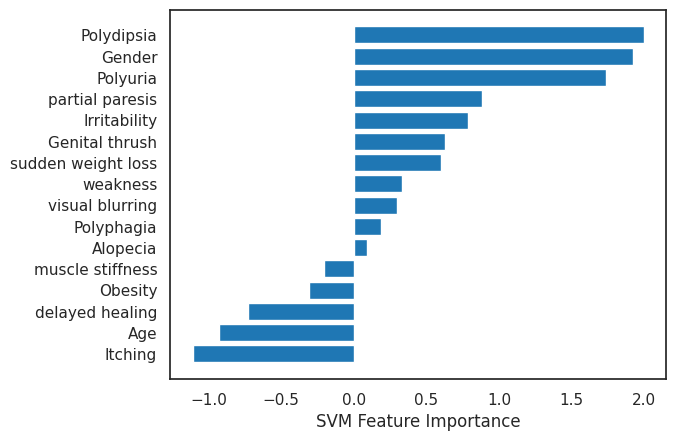

In [130]:
sorted_idx = best_model_svm.coef_[0].argsort()
plt.barh(X.columns[sorted_idx], best_model_svm.coef_[0][sorted_idx])
plt.xlabel("SVM Feature Importance")

In [131]:
svm_df = pd.DataFrame([['SVM Linear', precision_svm, recall_svm, accuracy_svm, f1_svm, accuracy_bal_svm]],columns=columns)
models_performance = pd.concat([models_performance,svm_df],ignore_index=True)

In [132]:
models_performance

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918
1,Naive Bayes Classifier,0.931,0.944,0.913,0.937,0.896
2,XGBoost Classifier,1.000,0.958,0.971,0.978,0.979
3,Random Forest Classifier,1.000,0.986,0.990,0.993,0.993
4,SVM Linear,0.957,0.944,0.933,0.950,0.926


## 5.6 Decision Tree Classifier

In [133]:
dtc_model = DecisionTreeClassifier(criterion='entropy', splitter='best', max_features='sqrt', random_state=42)
model_dtc = dtc_model.fit(X_train,y_train)

In [134]:
cv_results_dtc = cross_validate(dtc_model,
                            X=X_train,
                            y=y_train,
                            cv=5, # Number of folds
                            return_train_score=True,
                            return_estimator=True,
                            scoring=('balanced_accuracy'),
                            )

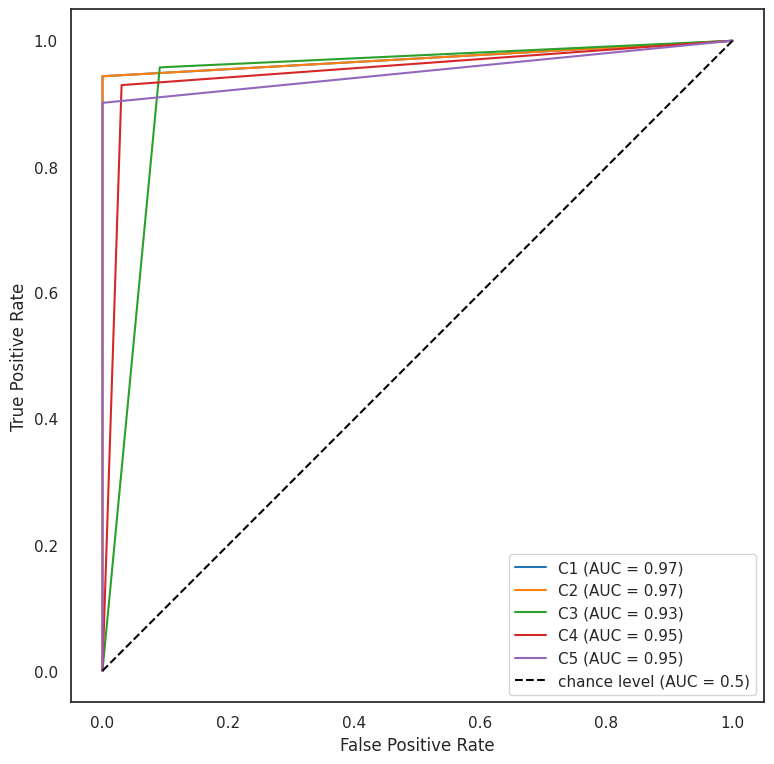

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid, model in enumerate(cv_results_dtc['estimator']):
  pred_score = model.predict_proba(X_test)
  # Get Probabilites only for the positive class
  pred_score = pred_score[:, 1]

  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=pred_score,
    name=f"C{cid+1}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      0.94      0.97        71

    accuracy                           0.96       104
   macro avg       0.95      0.97      0.96       104
weighted avg       0.97      0.96      0.96       104



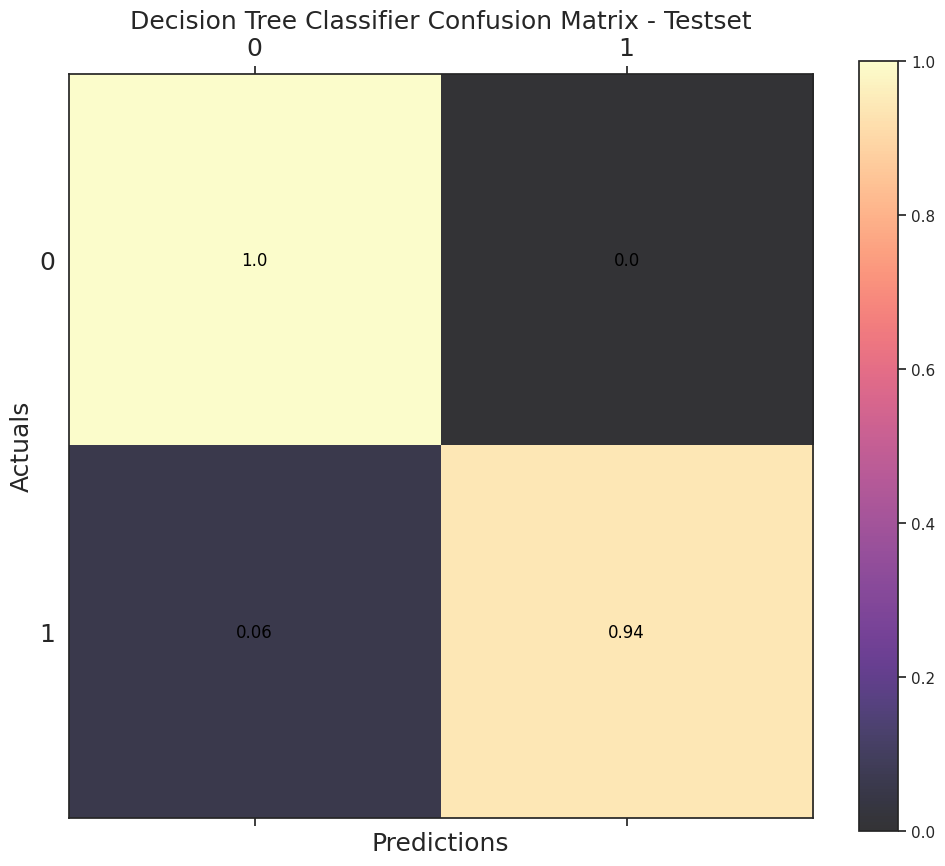

In [136]:
best_model_dtc = cv_results_dtc['estimator'][0]
test_pred_dtc = best_model_dtc.predict(X_test)

print(classification_report(y_test, test_pred_dtc))

conf_matrix_dtc = confusion_matrix(y_test, test_pred_dtc, normalize='true')
conf_matrix_dtc = np.round(conf_matrix_dtc, 2)
plot_confusion_matrix(conf_matrix_dtc, title='Decision Tree Classifier Confusion Matrix - Testset')

In [137]:
# model precision
precision_dtc = round(m.precision_score(y_test, test_pred_dtc),3)
# recall
recall_dtc = round(m.recall_score(y_test, test_pred_dtc),3)
# model accuracy
accuracy_dtc = round(m.accuracy_score(y_test, test_pred_dtc),3)
# f1-score
f1_dtc = round(m.f1_score(y_test, test_pred_dtc),3)
# mcc
mcc_dtc = round(m.matthews_corrcoef(y_test, test_pred_dtc),3)
#Roc_auc
roc_dtc = round(m.roc_auc_score(y_test,test_pred_dtc),3)
#Acc_bal
accurary_bal_xgb = round(m.balanced_accuracy_score(y_test,test_pred_dtc),3)

print("precision: {}" .format(precision_dtc))
print("recall: {}" .format(recall_dtc))
print("accuracy {}".format(accuracy_dtc))
print("f1 {}".format(f1_dtc))
print("mcc {}".format(mcc_dtc))
print("roc {}".format(roc_dtc))
print("accuracy balanced {}".format(accurary_bal_xgb))

precision: 1.0
recall: 0.944
accuracy 0.962
f1 0.971
mcc 0.917
roc 0.972
accuracy balanced 0.972


In [138]:
best_model_dtc.feature_importances_

array([0.08426913, 0.0544509 , 0.30280319, 0.05510325, 0.13672581,
       0.00847749, 0.0739932 , 0.02537246, 0.02632171, 0.03517499,
       0.02460246, 0.03429229, 0.04744255, 0.01091315, 0.05671509,
       0.02334233])

Text(0.5, 0, 'Decision Tree Feature Importance')

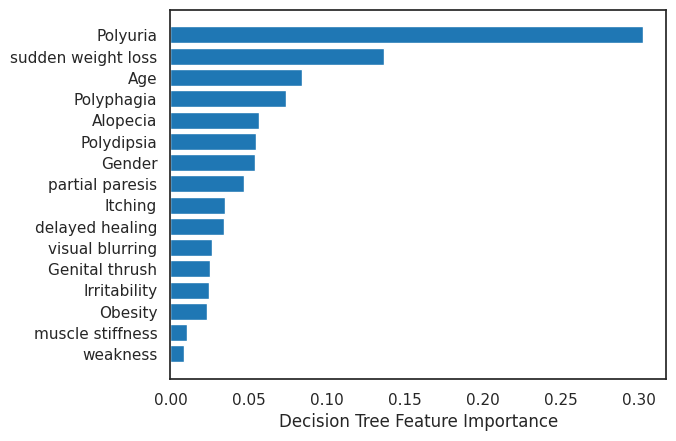

In [139]:
sorted_idx = best_model_dtc.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], best_model_dtc.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")

In [140]:
dtc_df = pd.DataFrame([['Decision Tree Classifier', precision_dtc, recall_dtc, accuracy_dtc, f1_dtc, accurary_bal_xgb]],columns=columns)
models_performance = pd.concat([models_performance,dtc_df],ignore_index=True)

In [141]:
# With normalization
models_performance.sort_values('F1_Score', ascending=False)

,Model,Precision,Recall,Accuracy,F1_Score,Balanced Accuracy
3,Random Forest Classifier,1.000,0.986,0.990,0.993,0.993
2,XGBoost Classifier,1.000,0.958,0.971,0.978,0.979
5,Decision Tree Classifier,1.000,0.944,0.962,0.971,0.972
0,Logistic Regression,0.944,0.958,0.933,0.951,0.918
4,SVM Linear,0.957,0.944,0.933,0.950,0.926
1,Naive Bayes Classifier,0.931,0.944,0.913,0.937,0.896


In [142]:
#Table with models used to project
models_final = models_performance[(models_performance['Model']=='Random Forest Classifier')|(models_performance['Model']=='XGBoost Classifier')|(models_performance['Model']=='SVM Linear')|(models_performance['Model']=='Naive Bayes Classifier')]

# 6.0 Result Analysis

In [145]:
# Resultado final
df_result = models_final[['Model','Accuracy','Balanced Accuracy','F1_Score','Recall','Precision']]

In [144]:
# Visualização do resultado final
df_result.sort_values('F1_Score', ascending=False)

,Model,Accuracy,Balanced Accuracy,F1_Score,Recall,Precision
3,Random Forest Classifier,0.990,0.993,0.993,0.986,1.000
2,XGBoost Classifier,0.971,0.979,0.978,0.958,1.000
4,SVM Linear,0.933,0.926,0.950,0.944,0.957
1,Naive Bayes Classifier,0.913,0.896,0.937,0.944,0.931


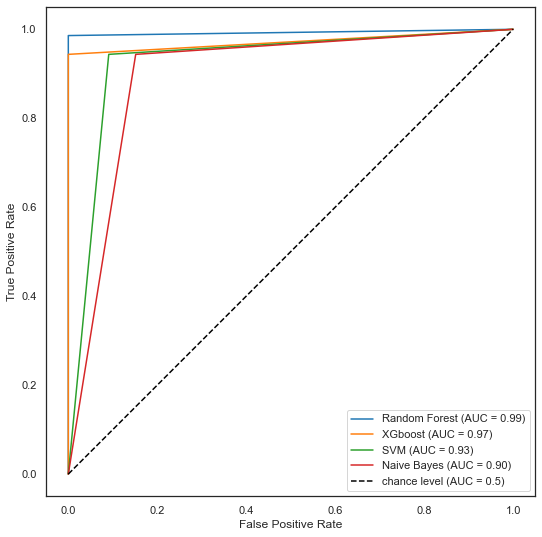

In [ ]:
# Curva ROC
y_pred_roc = [test_pred_rfc,test_pred_xgb,test_pred_svm,test_pred_nbc]
models_name = ['Random Forest','XGboost','SVM','Naive Bayes']
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

for cid in range(4):
  RocCurveDisplay.from_predictions(
    y_true=y_test,
    y_pred=y_pred_roc[cid],
    name=f"{models_name[cid]}",
    color=f"C{cid}",
    pos_label=1, ax = ax
    )
  ax.axis('square')
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()